# Code for <br> Vincent 2015: A tutorial on Bayesian Models of Perception

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *


In [16]:
import pymc as pm
import arviz as az
import scipy.io as sio
from scipy import stats
# from scipy.stats import percentileofscore

### Load Configs

In [7]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
sorted_dir = Path(dir_config.data.sorted)

### Utils functions

In [23]:
def m1posteriorPrediction(T, si, variance):
    """
    Generate random samples of k based on the given parameters.

    Parameters:
    - T: Number of trials
    - si: Stimulus intensities (scalar or array)
    - variance: Variance parameter (scalar)

    Returns:
    - k: Random samples of k based on the generated binomial distribution
    - PCc: Probability of correct response (scalar or array)
    """

    # Calculate PC using normal CDF
    PCc = stats.norm.cdf(si / np.sqrt(2 * variance))
    
    # Sample from binomial distribution
    k = np.random.binomial(T, PCc)

    return k, PCc


#### True Model Parameters

In [35]:
true_variance = 1
true_T = 100
true_si = np.logspace(-2, 2, 10)
true_bias = 0
true_lapse_rate = 0.01
true_prior = [0.5, 0.5]

In [34]:
np.log(true_si)


array([-4.60517019, -3.58179903, -2.55842788, -1.53505673, -0.51168558,
        0.51168558,  1.53505673,  2.55842788,  3.58179903,  4.60517019])

### Model 1: Statistical Decision Theory with Bayesian estimates

#### 1. Simulate dataset

In [36]:
np.random.seed(42)  # For reproducibility
data = {
    "sioriginal": true_si, # example stimulus intensity
    "T": true_T, # number of trials
    "muN": 0, # mean of the prior
    "v": true_variance, # standard deviation of the prior
}
data["ni"] = 41 # number of iterations
data["sii"] =  np.logspace(-2, 2, data["ni"]) #  interpolated stimulus intensities
data["si"] = np.concatenate([data['sioriginal'], data['sii']]) 
# Generate data['koriginal'] by simulating counts
data["koriginal"], _ = m1posteriorPrediction(data['T'], data['sioriginal'], data['v'])


#### 2. Parameter Recovery

In [13]:
# define the model

with pm.Model() as model:
    # Prior
    variance = pm.Uniform("variance", lower=0, upper=1000)
    
    # Likelihood
    
    
    


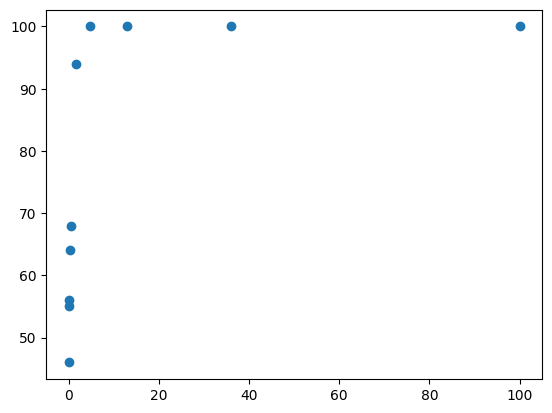

In [14]:
plt.plot(data["sioriginal"], observed_counts, "o")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [variance]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
variance  0.438  0.117   0.244    0.639      0.005    0.004     460.0   

          ess_tail  r_hat  
variance     676.0    NaN  


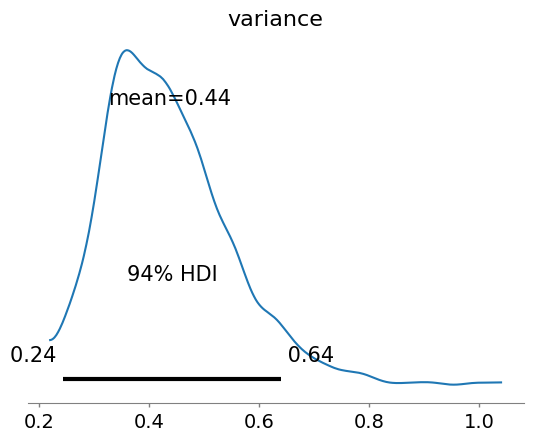

Sampling: [predk]


Output()

KeyError: 'predk'

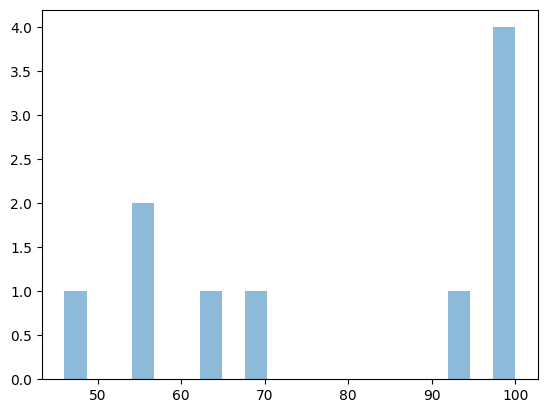

In [9]:





# Summarize the original counts
observed_counts = np.sum(data["koriginal"] > 0, axis=1)  # Counts of correct responses per stimulus intensity

# Define the probabilistic model
with pm.Model() as model:
    # Prior for the variance
    variance = pm.Uniform('variance', lower=0, upper=1000)
    
    # Likelihood
    predk = pm.Binomial('predk', n=data['T'], p=pm.math.invlogit(data['sioriginal'] / pm.math.sqrt(variance)), observed=observed_counts)
    
    # Inference
    trace = pm.sample(1000, chains=1, return_inferencedata=True)

# Summarize the trace
print(az.summary(trace, var_names=["variance"]))

# Plot the posterior distribution of variance
az.plot_posterior(trace, var_names=["variance"])
plt.show()

# Predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["predk"], random_seed=42)

# Plot the observed vs. predicted counts
fig, ax = plt.subplots()
ax.hist(observed_counts, bins=20, alpha=0.5, label='Observed')
ax.hist(ppc['predk'].flatten(), bins=20, alpha=0.5, label='Predicted')
ax.legend()
plt.show()
